<a href="https://colab.research.google.com/github/JennyPre/ReinforcementSimple/blob/main/LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install gymnasium
! pip install torch torchvision
! pip install numpy matplotlib
! pip install imageio imageio-ffmpeg
! pip install mediapy
! pip install swig
! pip install "gymnasium[box2d]"

  Using cached box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl
  Using cached pygame-2.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached pygame-2.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pygame]2m1/2 [pygame]


In [8]:
import gymnasium as gym
import mediapy as media

# Lunar Lander

This problem represents an optimization problem, where the engine is either full on or turned of (Pontryagin's maximum principle).

The rockets trajectory should be optimized such that the rocket lands at the landing area (0,0). Environment is either discrete or continuous, here a discrete environment will be used.

The amount of fuel is not restricted, which is beneficial for learning.


Without learning, a heuristic landing run looks like this
```!python /content/lunar_lander.py```


 | Step | x_position | y_position | x_velocity | y_velocity | angle | angular_velocity | left_leg_contact | right_leg_contact | Total Reward |
|------|------------|----------|------------|------------|-------|------------------|------------------|-------------------|--------------|
| 0    | -0.00      | +1.43    | -0.10      | +0.45      | +0.00 | -0.02            | +0.00            | +0.00             | +1.85        |
| 20   | -0.02      | +1.51    | -0.10      | -0.09      | -0.02 | -0.02            | +0.00            | +0.00             | +24.63       |
| 40   | -0.04      | +1.34    | -0.10      | -0.62      | -0.04 | -0.02            | +0.00            | +0.00             | -10.26       |
| 60   | -0.07      | +0.94    | -0.12      | -1.08      | -0.06 | -0.04            | +0.00            | +0.00             | -18.42       |
| 80   | -0.07      | +0.55    | +0.00      | -0.68      | -0.06 | -0.00            | +0.00            | +0.00             | +55.71       |
| 100  | -0.07      | +0.32    | +0.02      | -0.41      | -0.08 | +0.02            | +0.00            | +0.00             | +97.02       |
| 120  | -0.06      | +0.18    | +0.11      | -0.26      | -0.05 | +0.08            | +0.00            | +0.00             | +121.93      |
| 140  | -0.04      | +0.09    | +0.10      | -0.19      | +0.01 | +0.05            | +0.00            | +0.00             | +138.54      |
| 160  | -0.02      | +0.02    | +0.03      | -0.10      | +0.04 | +0.01            | +0.00            | +0.00             | +147.82      |
| 180  | -0.02      | -0.00    | +0.00      | +0.03      | -0.01 | +0.10            | +1.00            | +1.00             | +178.68      |
| 200  | -0.02      | -0.00    | -0.00      | -0.00      | -0.00 | +0.00            | +1.00            | +1.00             | +182.39      |
| 207  | -0.02      | -0.00    | +0.00      | +0.00      | -0.00 | +0.00            | +1.00            | +1.00             | +282.39      |



/home/jenny/anaconda3/envs/reinforcement-learning/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


""

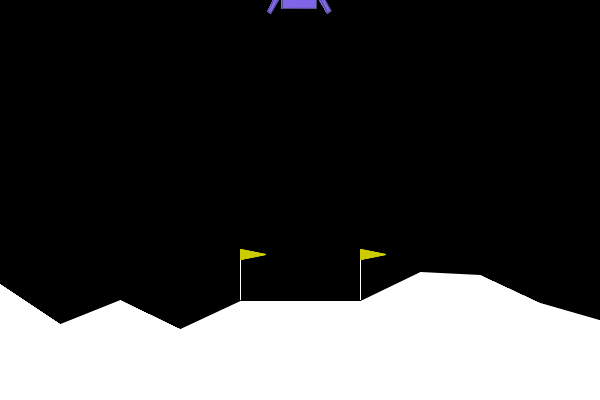

In [9]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

frames = []
observation, info = env.reset()
rewards = []


for t in range(100):
  action = env.action_space.sample()
  frames.append(env.render())
  observation, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated
  rewards.append(reward)

  if done:
    print(f"Episode finished after {t+1} timesteps. Cummulative return: {sum(rewards)}")
    break

media.show_video(frames, fps=10, codec='gif')

In [12]:
# ! python /content/lunar_lander.py

## Action Space

The action space allows four action, hence is discrete:

- do nothing (0)
- fire left orientation engine (1)
- fire main engine (2)
- fire right orientation engine (3)

## Observation Space

Is a vector:

```
(lander_x,
lander_y,
velocity_x,
velocity_y,
lander_angle,
angular_velocity,
left_leg_ground_contact,
right_leg_ground_contact
)
```

## Rewards


An episode consists of n steps, for each step a reward is given. The rewards are summed up within an episode.

The reward for a step is calculated as follows:

- distance to the landing pad
- moving speed of the lander
- angle of the lander (bigger angle leads to bigger decrease)
- +10 points for each leg on the ground
- -0.03 points per frame the side engine fires
- -0.3 points per frame the main engine fires

-100/+100: save landing

A successfull episode is an episode that scores at least 200 points.

In [13]:
print(env.action_space)  # Should be Discrete(4)

Discrete(4)


## Proximal Policy Optimization


PPO is an **Actor-Critic** policy gradient algorithm. It updates the policy within a "trust region" to avoid catastrophically worsening performance.


### Actor-Critic

PPO uses TWO neural networks (or two output heads from a shared network):

1. **Actor (Policy Network)**: Learns π_θ(a|s) - outputs action probability distribution
2. **Critic (Value Network)**: Learns V_ϕ(s) - outputs state-value estimates


This combines:
- **Policy-based**: Directly learns a policy (distribution over actions)
- **Value-based**: Learns a state-value function V(s) to estimate "how good is this state?"

```
┌─────────────────────────────────────────────────┐
│  CRITIC  =  Value Function  =  V(s)             │
│  "How good is this state?"                      │
│                                                 |
│  Input:  State s                                │
│  Output: Single number (estimated value)        │
│  Example: V(s) = 42.7                           │
└─────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────┐
│  ACTOR   =  Policy  =  π(a|s)                   │
│  "What action should I take?"                   │
│                                                 │
│  Input:  State s                                │
│  Output: Probability distribution over actions  │
│  Example: π(a|s) = [0.1, 0.7, 0.2, 0.0]         │
└─────────────────────────────────────────────────┘
```



### Policy Ratio

This ratio describes the relation between old and new policies. A policy is parameterized by the weights of it's neural network θ, and is depdendent on the states $s$ and actions $a$:

$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

- If r_t > 1: action became more likely under new policy
- If r_t < 1: action became less likely under new policy

## Objective Function

The PPO maximizes the following clipped objective. The clipping will prevent large policy updates.


$$L^{CLIP}(\theta) = \mathbb{E}_t[\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

The clipping restricts r_t to [1-ε, 1+ε].

### Advantage Function (GAE)

This function quantifies how much better an action was than expected. For PPO Generalized Advantage Estimation (GAE) is often used:

$$\hat{A}_t = \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ...$$

where
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error,
  - $V(s_t)$ = **critic's estimate** of current state value
  - $V(s_{t+1})$ = **critic's estimate** of next state value
- $\gamma$: discount factor
- $\lambda$ controls the bias-variance tradeoff.



### Loss Function

The loss function combines three terms:

$$L(\theta) = L^{CLIP}(\theta) - c_1 L^{VF}(\theta) + c_2 S[\pi_\theta](s_t)$$

where:
- $L^{CLIP}$ = **Actor loss** (policy gradient with clipping)
- $L^{VF} = (V_\theta(s_t) - V_t^{target})^2$ = **Critic loss** (MSE between predicted and actual returns)
- $S[\pi_\theta] = -\sum_a \pi_\theta(a|s)\log\pi_\theta(a|s)$ = **Entropy bonus** (encourages exploration)
- $c_1$ ≈ 0.5, $c_2$ ≈ 0.01 (typical coefficients)


## PPO Algorithm

The algorithm repeatedly alternates between data collection and policy updates:

1. The agent interacts with the environment using the current policy, collecting trajectories of $(s_t, a_t, r_t, s_{t+1})$ tuples. It also computes V(s_t) for each state using the **critic network**
2. Compute Advantages:
   - Calculate temporal difference errors: δ_t = r_t + γ·V(s_{t+1}) - V(s_t)
   - Calculate GAE advantages: Â_t using the TD errors
   - Calculate target returns: V_t^{target} for training the critic
3. Shuffle the collected data and update the policy network and critic network multiple epochs (typically 3-10) using minibatches, optimizing the full loss function
4. Repeat


PPO reuses the same batch of experience multiple times, before collecting new data. This makes it more sample-efficient compared to vanilla policy gradients.



In [11]:
# Reset the environment to generate new observations
observation, info = env.reset(seed=42)

for _ in range(1000):

    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

## TODO: Q-learning

## TODO: DQN-Agent



## Stable-Baselines3